In [144]:
from zipfile import ZipFile
from pathlib import Path
import xml.etree.ElementTree as ET
from collections import Counter, defaultdict
from tqdm.notebook import tqdm, trange
import datetime
import matplotlib.pyplot as plt
import random
import json
import imageio
from io import BytesIO
#import visvis

In [131]:
!conda install -c conda-forge -y visvis

Solving environment: ...working... done

## Package Plan ##

  environment location: F:\Anaconda\envs\prv_kemi

  added / updated specs:
    - visvis


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.8  |       h5b45459_0         176 KB  conda-forge
    conda-4.10.3               |   py39hcbf5309_3         3.1 MB  conda-forge
    pyopengl-3.1.5             |             py_0         854 KB  conda-forge
    visvis-1.11.1              |             py_0         4.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.8 MB

The following NEW packages will be INSTALLED:

  pyopengl           conda-forge/noarch::pyopengl-3.1.5-py_0
  visvis             conda-forge/noarch::visvis-1.11.1-py_0

The following packages will be UPDATED:

  certifi            pkgs/main::certifi-2021.10.8-p

In [15]:
p = Path('F:/datasets/PRV_KEMI_DATA/patents/netto_list')
patent_files = sorted(p.glob('EP*.zip'))
len(patent_files)

17136

In [16]:
p_file = patent_files[-1]
p_file

WindowsPath('F:/datasets/PRV_KEMI_DATA/patents/netto_list/EP3758048NWA1.zip')

In [4]:
def load_patent_xml(patent_path):
    with ZipFile(patent_path) as patent_zip:
        filenames = [zipinfo.filename for zipinfo in patent_zip.infolist()]
        # We're just assuming the only XML apart from TOC.xml is the one we're looking for
        # Since the name of this document is based on the application number, not the 
        # publication number, we have to scan for it manually
        doc_xml = None
        for filename in filenames:
            *base, ext = filename.split('.')
            if ext == 'xml' and filename.lower() != 'toc.xml':
                doc_xml = filename
        if doc_xml is None:
            raise ValueError(f"Unable to find document xml for zipfile {patent_path}")
        
        with patent_zip.open(doc_xml) as patent_xml_fp:
            xml_str = str(patent_xml_fp.read(), encoding='utf8')
            root = ET.fromstring(xml_str)
            return root

In [164]:
def load_images_imageio(patent_path):
    with ZipFile(patent_path) as patent_zip:
        images = []
        for fileinfo in patent_zip.infolist():
            *parents, filename = fileinfo.filename.split('/')
            *baseparts, ext = filename.split('.')
            if ext == 'tif':
                with patent_zip.open(fileinfo) as fp:
                    image = imageio.imread(fp)
                    images.append((filename, image))
        return images

In [171]:
def load_images(patent_path):
    with ZipFile(patent_path) as patent_zip:
        images = []
        for fileinfo in patent_zip.infolist():
            *parents, filename = fileinfo.filename.split('/')
            *baseparts, ext = filename.split('.')
            if ext == 'tif':
                with patent_zip.open(fileinfo) as fp:
                    image = fp.read()
                    images.append((filename, image))
        return images

In [178]:
images = load_images(p_file)
name, im = images[0]
# png-encoded bytes string
# Note: defaults to RGB color space

#plt.imshow(im)

In [155]:
z = ZipFile('foo.zip', 'w')
im = images[0]
png_encoded = imageio.imwrite("<bytes>", im, format="PNG")
z.writestr('foo/bar/ara.png', png_encoded)


In [176]:
z.close()

In [106]:
def numbered_text(paragraph):
    text = ''
    if 'num' in paragraph.attrib:
        num = paragraph.attrib['num']
        text = f'[{num}] '
    text += ''.join(paragraph.itertext())
    return text

def get_texts(elements):
    text_dict = {}
    
    for element in elements:
        lang = element.attrib['lang']
        texts = '\n'.join(numbered_text(c) for c in element)
        text_dict[lang] = texts
    return text_dict

In [151]:
def extract_patent_info(patent_path):
    patent_info = dict()
    root = load_patent_xml(patent_path)
    # The root element is the 'ep-patent-document', which has an attribute called date-publ, the publication date
    publication_date_str = root.attrib['date-publ']
    #publication_date = datetime.datetime.strptime(publication_date_str, '%Y%m%d')
    patent_info['publication_date'] = publication_date_str

    doc_country = root.attrib['country']
    doc_number = root.attrib['doc-number']
    doc_kind = root.attrib['kind']
    patent_info['document_number'] = f'{doc_country}{doc_number}.{doc_kind}'

    ipcr_classes = root.findall('.//SDOBI//classification-ipcr/text')
    text_classes = [e.text for e in ipcr_classes]
    # The class string has the form 'A61K  38/44        20060101AFI20130522BHEP        '
    # We first split by white space and only select the first two parts
    split_classes = [text.split() for text in text_classes]
    selected_parts = [(main_class, sub_class) for main_class, sub_class, *_ in split_classes]
    patent_info['ipc_classes'] = selected_parts

    patent_info['abstract'] = get_texts(root.findall('abstract'))
    patent_info['claims'] = get_texts(root.findall('claims'))
    patent_info['description'] = get_texts(root.findall('description'))
    
    applicants = root.findall('.//SDOBI//B711/snm')
    text_applicants = [e.text for e in applicants]
    patent_info['applicants'] = text_applicants

    language, = root.findall('.//SDOBI/B200/B260')
    language_text = language.text
    patent_info['language'] = language_text


    return patent_info

In [177]:
with ZipFile('patents.zip', 'w') as patents_fp:
    for patent_file in tqdm(patent_files, desc='Patent files'):
        patent_info = extract_patent_info(patent_file)
        patent_number = patent_info['document_number']
        patents_fp.writestr(patent_number + '/patent_info.json', json.dumps(patent_info, sort_keys=True, indent=2))
        
        images = load_images(patent_file)
        for image_name, image in images:
            patents_fp.writestr(f'{patent_number}/{image_name}', image)
        

Patent files:   0%|          | 0/17136 [00:00<?, ?it/s]

In [108]:
extract_patent_info(p_file)['description']

{'en': 'Technical Field\n[0001] The present invention relates to a bonding joining structure, and more particularly relates to a bonding joining structure that is preferably used as a die bonding joining structure between a die of a semiconductor device and a metal support.\nBackground Art\n[0002] With regard to bonding of a semiconductor device, Patent Document 1 discloses a semiconductor apparatus having: a semiconductor device that has a collector electrode on one surface and an emitter electrode on the other surface; and an insulating substrate that has a first electrode interconnect on one surface. The first electrode interconnect of the insulating substrate and the collector electrode of the semiconductor device are connected to each other via a first bonding layer. This first bonding layer is a sintered layer obtained by sintering a bonding material and a reducing agent. The bonding material contains a metal particle precursor that is composed of silver carbonate and the like. T

In [68]:
print('\n'.join(''.join(c.itertext()) for c in description))

Technical Field
The present invention relates to a bonding joining structure, and more particularly relates to a bonding joining structure that is preferably used as a die bonding joining structure between a die of a semiconductor device and a metal support.
Background Art
With regard to bonding of a semiconductor device, Patent Document 1 discloses a semiconductor apparatus having: a semiconductor device that has a collector electrode on one surface and an emitter electrode on the other surface; and an insulating substrate that has a first electrode interconnect on one surface. The first electrode interconnect of the insulating substrate and the collector electrode of the semiconductor device are connected to each other via a first bonding layer. This first bonding layer is a sintered layer obtained by sintering a bonding material and a reducing agent. The bonding material contains a metal particle precursor that is composed of silver carbonate and the like. The reducing agent is comp

In [105]:
downloaded_patents = set()
yearly_patents = defaultdict(set)
yearly_patent_classes = defaultdict(Counter)
yearly_patents_to_classes = defaultdict(dict)
error_patents = []
for patent_path in tqdm(patent_files, desc='Processing patent files'):
    try:
        patent_info = extract_patent_info(patent_path)
        patent_number = patent_info['document_number']
        downloaded_patents.add(patent_number)
        year = patent_info['publication_date'].year
        patent_classes = patent_info['ipc_classes']
        yearly_patents[year].add(patent_number)
        yearly_patent_classes[year].update(patent_classes)
        yearly_patents_to_classes[year][patent_number] = patent_classes
    except BaseException as e:
        #print(f"Error with patent {patent_path}, {e}")
        error_patents.append(patent_path)
    



Processing patent files:   0%|          | 0/15525 [00:00<?, ?it/s]

In [77]:
yearly_patents

defaultdict(set,
            {2012: {'EP2457846.A2',
              'EP2474861.A1',
              'EP2476713.A1',
              'EP2477224.A2',
              'EP2479157.A2',
              'EP2479206.A1',
              'EP2479207.A1',
              'EP2479208.A1',
              'EP2479215.A1',
              'EP2481390.A1',
              'EP2481391.A2',
              'EP2481568.A1',
              'EP2481775.A1',
              'EP2481776.A1',
              'EP2481847.A1',
              'EP2482372.A2',
              'EP2484522.A2',
              'EP2484706.A1',
              'EP2484721.A1',
              'EP2484732.A1',
              'EP2484749.A1',
              'EP2487043.A1',
              'EP2487044.A1',
              'EP2487215.A1',
              'EP2487544.A1',
              'EP2489441.A1',
              'EP2489492.A1',
              'EP2489493.A2',
              'EP2489637.A1',
              'EP2489677.A1',
              'EP2489678.A1',
              'EP2489679.A1',
              'EP

In [61]:
p = Path('F:/datasets/PRV_KEMI_DATA/patents') /'downloaded_netto_list_patents.txt'
with open(p, 'w') as fp:
    fp.write('\n'.join(sorted(downloaded_patents)))

In [63]:
yearly_patent_classes_coarse = defaultdict(Counter)
for year, class_counts in yearly_patent_classes.items():
    for (main_class, sub_class), count in class_counts.items():
        yearly_patent_classes_coarse[year][main_class] += count

In [64]:
yearly_patent_classes_coarse

defaultdict(collections.Counter,
            {2012: Counter({'B65D': 1,
                      'G03F': 20,
                      'C08G': 63,
                      'H01L': 10,
                      'C08L': 40,
                      'C09J': 24,
                      'C08K': 15,
                      'C04B': 21,
                      'C08J': 12,
                      'G03G': 6,
                      'B29B': 1,
                      'B29C': 9,
                      'B32B': 10,
                      'A61K': 26,
                      'E04C': 1,
                      'D06M': 9,
                      'D04C': 1,
                      'D07B': 2,
                      'H01M': 3,
                      'H05K': 2,
                      'B41C': 5,
                      'C03C': 1,
                      'C09K': 1,
                      'G02B': 3,
                      'C09D': 31,
                      'B29D': 1,
                      'H01B': 5,
                      'C12M': 1,
                      'G01

([<matplotlib.axis.XTick at 0x1b6d6548fa0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

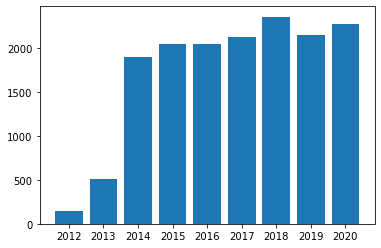

In [79]:
patents_per_year = {year: len(patents) for year,patents in yearly_patents.items()}
years, n_patents = zip(*sorted(patents_per_year.items()))
x_years = list(range(min(years), max(years)+1))
plt.bar(years, n_patents)
plt.xticks(x_years)

In [10]:
import csv
output_dir = Path('F:/datasets/PRV_KEMI_DATA/class_lists')
output_dir.mkdir(parents=True, exist_ok=True)
with open(output_dir/'fine_grained_by_rank.csv', 'w') as fp:
    row_format = '{main_class},{sub_class},{count}\n'
    fp.write(row_format.format(main_class='main_class', sub_class='sub_class', count='count'))
    for (main_class, sub_class), count in patent_classes.most_common():
        fp.write(row_format.format(main_class=main_class, sub_class=sub_class, count=count))

In [12]:
import csv
output_dir = Path('F:/datasets/PRV_KEMI_DATA/class_lists')
output_dir.mkdir(parents=True, exist_ok=True)
min_count = 100
with open(output_dir/f'fine_grained_freq_above_{min_count}.txt', 'w') as fp:
    for (main_class, sub_class), count in patent_classes.most_common():
        if count > min_count:
            fp.write(f'{main_class}{sub_class}\n')
        else:
            break

In [83]:
main_classes = Counter()
for year, class_counts in yearly_patent_classes_coarse.items():
    for main_class, count in class_counts.items():
        main_classes[main_class] += count

In [106]:
most_common_coarse_20 = main_classes.most_common(20)
most_common_coarse_20_set = set(main_class for main_class, count in main_classes.most_common(20))
most_common_coarse_20

[('C08G', 9012),
 ('C08L', 6909),
 ('C08K', 4900),
 ('C09D', 4461),
 ('A61K', 3956),
 ('B32B', 2792),
 ('C08F', 2577),
 ('C09J', 2533),
 ('C08J', 2451),
 ('C07C', 1561),
 ('C10M', 1459),
 ('C09K', 1329),
 ('C10N', 1287),
 ('A61Q', 1125),
 ('B29C', 1096),
 ('C07D', 917),
 ('H01L', 893),
 ('G02B', 774),
 ('G03F', 754),
 ('B41M', 605)]

In [102]:
desired_sample_size = defaultdict(dict)
sample_ratio = 1  # How many negative samples compared to positives. 1 means 1-to-1, 1 negative per positive

for year, class_counts in yearly_patent_classes_coarse.items():
    for ipc_class, count in class_counts.items():
        if ipc_class in most_common_coarse_20:
            desired_sample_size[year][ipc_class] = int(count*sample_ratio)

In [103]:
p = Path('F:/datasets/PRV_KEMI_DATA/') / f'desired_sample_size_with_sample_ratio_{sample_ratio}.json'
with open(p, 'w') as fp:
    json.dump(desired_sample_size, fp, sort_keys=True, indent=2)

In [ ]:
output_dir = Path('F:/datasets/PRV_KEMI_DATA/class_lists')
output_dir.mkdir(parents=True, exist_ok=True)
with open(output_dir/'most_common_20_coarse_classes.txt', 'w') as fp:
    for ipc_name, count in main_classes.most_common(20):
        fp.write(f'{ipc_name}\n')

In [57]:
extract_ipcr_classes(patent_path)

[('H01L', '21/52'),
 ('B22F', '7/08'),
 ('H01L', '21/02'),
 ('B22F', '7/00'),
 ('B22F', '7/04'),
 ('B22F', '7/06'),
 ('H01L', '23/00'),
 ('H01L', '23/495'),
 ('H01L', '23/34'),
 ('H01L', '21/477'),
 ('C09K', '5/14')]

In [40]:
ipcr_classes

[<Element 'classification-ipcr' at 0x0000018858D7FEF0>,
 <Element 'classification-ipcr' at 0x0000018858D7FF90>,
 <Element 'classification-ipcr' at 0x0000018858D84090>,
 <Element 'classification-ipcr' at 0x0000018858D84130>,
 <Element 'classification-ipcr' at 0x0000018858D841D0>,
 <Element 'classification-ipcr' at 0x0000018858D84270>]

'A61K  38/44        20060101AFI20130522BHEP        '

In [13]:
for child in root:
    print(child.tag, child.attrib)

NameError: name 'root' is not defined

The above doesn't work, since it effectively double counts lots of documents (the sample we get is about two times the size ). Instead we sample a class from each document proportional to the frequency of the most common classes. 

This does the sampling without replacement, but the issue is that some patents don't have any classes in the most common 20. Below this we have a routine which dies the sampling with replacement among the documents which has relevant classes, thus ensuring we have as many documents

In [134]:
random.seed(1729)
sample_ratio = 1.5  # How many negative samples compared to positives. 1 means 1-to-1, 1 negative per positive
desired_sample_size = defaultdict(Counter)
most_common_coarse_20_map = dict(most_common_coarse_20)
no_common_class_patents = []
for year, patents_to_classes in yearly_patents_to_classes.items():
    for patent_number, classes in patents_to_classes.items():
        common_class_occurance = [(main_class, most_common_coarse_20_map[main_class]) for main_class, sub_class in classes if main_class in most_common_coarse_20_map]
        if len(common_class_occurance) == 0:
            no_common_class_patents.append(patent_number)
        else:
            occured_classes, counts = zip(*common_class_occurance)
            total_count = sum(counts)
            class_probabilities = [count/total_count for count in counts]
            [sampled_class,] = random.choices(occured_classes, weights=class_probabilities)
            desired_sample_size[year][sampled_class] += 1
    
len(no_common_class_patents)

1746

In [135]:
desired_sample_size

defaultdict(collections.Counter,
            {2012: Counter({'G03F': 9,
                      'C08G': 21,
                      'C08L': 14,
                      'C08J': 8,
                      'A61K': 13,
                      'B32B': 3,
                      'C08K': 3,
                      'C09D': 15,
                      'B41M': 5,
                      'C08F': 2,
                      'B29C': 3,
                      'H01L': 1,
                      'G02B': 2,
                      'C09J': 4,
                      'C10N': 2,
                      'A61Q': 2}),
             2013: Counter({'A61K': 47,
                      'C09D': 49,
                      'C08G': 90,
                      'C08L': 75,
                      'C08K': 47,
                      'B32B': 19,
                      'C09J': 22,
                      'C08J': 19,
                      'G02B': 7,
                      'C07C': 13,
                      'C08F': 6,
                      'C10M': 5,
                

In [126]:
p = Path('F:/datasets/PRV_KEMI_DATA/') / f'desired_sample_size_with_sample_ratio_{sample_ratio}.json'
with open(p, 'w') as fp:
    json.dump(desired_sample_size, fp, sort_keys=True, indent=2)

This samples the document we pick for classes, instead of doing it once for every class. This guarantees that we get as many documents in the complement as we have in the netto list

In [133]:
samples_per_year = {year: int(len(patents)*sample_ratio) for year, patents in yearly_patents.items()}
sum(samples_per_year.values())

15525

In [149]:
random.seed(1729)
sample_ratio = 1.1  # How many negative samples compared to positives. 1 means 1-to-1, 1 negative per positive
most_common_coarse_20_map = dict(most_common_coarse_20)

samples_per_year = {year: int(len(patents)*sample_ratio) for year, patents in yearly_patents.items()}
filtered_documents = defaultdict(dict)

for year, patents_to_classes in yearly_patents_to_classes.items():
    for patent_number, classes in patents_to_classes.items():
        common_class_occurance = [(main_class, most_common_coarse_20_map[main_class]) for main_class, sub_class in classes if main_class in most_common_coarse_20_map]
        if len(common_class_occurance) > 0:
            occured_classes, counts = zip(*common_class_occurance)
            total_count = sum(counts)
            class_probabilities = [count/total_count for count in counts]
            filtered_documents[year][patent_number] = (occured_classes, class_probabilities)
            


desired_sample_size = defaultdict(Counter)
for year, samples in samples_per_year.items():
    yearly_patent_classes = list(filtered_documents[year].values())
    for i in range(samples):
        (occured_classes, class_probabilities) = random.choice(yearly_patent_classes)
        [sampled_class,] = random.choices(occured_classes, weights=class_probabilities)
        desired_sample_size[year][sampled_class] += 1



In [150]:
sum(count for year, class_counts in desired_sample_size.items() for ipc_class, count in class_counts.items())

17074

In [151]:
desired_sample_size

defaultdict(collections.Counter,
            {2012: Counter({'C08L': 24,
                      'C09D': 24,
                      'B29C': 7,
                      'C08G': 22,
                      'G03F': 16,
                      'C08J': 8,
                      'A61K': 20,
                      'A61Q': 6,
                      'C09J': 7,
                      'C09K': 1,
                      'B41M': 6,
                      'C08K': 6,
                      'G02B': 2,
                      'C08F': 1,
                      'C07D': 3,
                      'B32B': 3,
                      'C10N': 1}),
             2013: Counter({'C09D': 66,
                      'C08L': 99,
                      'C08G': 113,
                      'A61K': 59,
                      'B41M': 2,
                      'C09J': 38,
                      'C07D': 9,
                      'C08K': 68,
                      'B32B': 12,
                      'G03F': 12,
                      'C08F': 14,
              

In [152]:
p = Path('F:/datasets/PRV_KEMI_DATA/') / f'desired_sample_size_with_sample_ratio_{sample_ratio}.json'
with open(p, 'w') as fp:
    json.dump(desired_sample_size, fp, sort_keys=True, indent=2)